In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tsmoothie.smoother import GaussianSmoother
import spikeinterface
import spikeinterface.full as si
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import spikeinterface.postprocessing as sp
import spikeinterface.preprocessing as spre
import spikeinterface.qualitymetrics as qm
import helper_functions as helper

In [2]:
#Reading the file, BP filtering
local_path= '/mnt/disk15tb/jonathan/Syngap3/Syngap3/230111/16873/Network/000238/data.raw.h5' #network data from chip 16848

recording1 = se.read_maxwell(local_path)



#recording = si.ConcatenateSegmentRecording([recording1,recording2])
channel_ids = recording1.get_channel_ids()
fs = recording1.get_sampling_frequency()
num_chan = recording1.get_num_channels()
num_seg = recording1.get_num_segments()
total_recording = recording1.get_total_duration()

#print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)
print('Number of segments:', num_seg)
print(f"total_recording: {total_recording} s")

recording_bp = spre.bandpass_filter(recording1, freq_min=300, freq_max=1000)

recodring_cmr = spre.common_reference(recording_bp, reference='global', operator='median')
#recording_chunk = recodring_cmr.frame_slice(start_frame= 1*fs,end_frame=425*fs)
recording_chunk = recodring_cmr.frame_slice(start_frame= 0*fs,end_frame=299*fs)
print(f"chunk duration: {recording_chunk.get_total_duration()} s")


Sampling frequency: 20000.0
Number of channels: 1004
Number of segments: 1
total_recording: 299.99 s
chunk duration: 299.0 s


In [ ]:
import os 
os.environ['HDF5_PLUGIN_PATH']='/home/mmp/Documents/Maxlab/so/'

In [ ]:
recording1.auto_install_maxwell_hdf5_compression_plugin() 

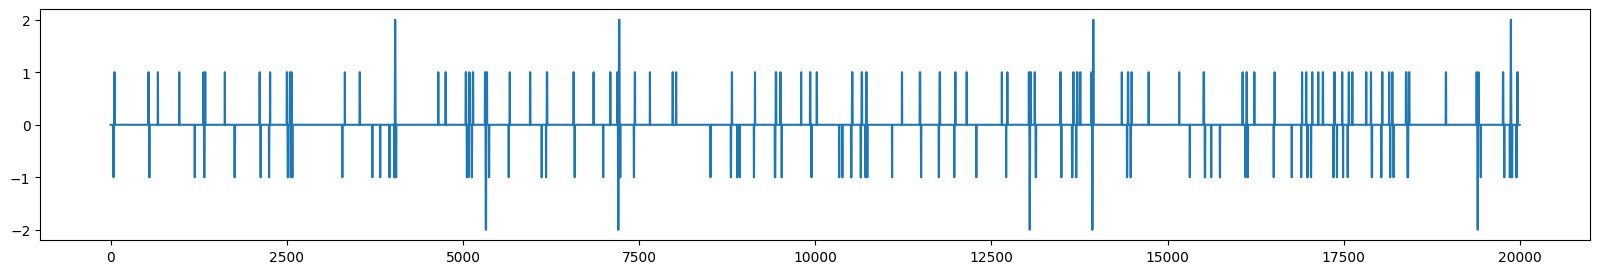

In [3]:
rectmp = recording_chunk.frame_slice(start_frame=int(13.75*fs),end_frame=int(14.75*fs))
traces_unscaled = rectmp.get_traces(return_scaled=False)
plt.figure(figsize=(20,3))
plt.plot(traces_unscaled[:, 424], label="unscaled")
#plt.legend()
#plt.savefig()
plt.show()

In [ ]:
ss.get

In [ ]:
rec2 = recording_chunk.save(n_jobs=64)

In [ ]:
# default_KS2_params = ss.get_default_sorter_params('spykingcircus2')
# run_sorter = ss.run_sorter(sorter_name='spykingcircus2',recording=recording_chunk, output_folder="./sorting/RG2_13Oct_sypkingcircus", verbose=True, **default_KS2_params)
# print(default_KS2_params)

In [5]:

default_KS2_params = ss.get_default_sorter_params('kilosort2')
print(default_KS2_params)
default_KS2_params['keep_good_only'] = True
# default_KS2_params['detect_threshold'] = 12
# default_KS2_params['projection_threshold']=[18, 10]
# default_KS2_params['preclust_threshold'] = 8

sorting_ks3 = ss.run_sorter('kilosort2',recording= recording_chunk, output_folder="./sorting/Syngap16873",docker_image= "si-98-ks2-maxwell",verbose=True, **default_KS2_params)

{'detect_threshold': 6, 'projection_threshold': [10, 4], 'preclust_threshold': 8, 'car': True, 'minFR': 0.1, 'minfr_goodchannels': 0.1, 'freq_min': 150, 'sigmaMask': 30, 'nPCs': 3, 'ntbuff': 64, 'nfilt_factor': 4, 'NT': None, 'AUCsplit': 0.9, 'wave_length': 61, 'keep_good_only': False, 'skip_kilosort_preprocessing': False, 'scaleproc': None, 'save_rez_to_mat': False, 'delete_tmp_files': True, 'delete_recording_dat': False, 'n_jobs': 48, 'chunk_duration': '1s', 'progress_bar': True}
Starting container
spikeinterface is already installed in si-98-ks2-maxwell
Installing extra requirements: ['neo', 'h5py']
Running kilosort2 sorter inside si-98-ks2-maxwell
Stopping container


In [7]:
sorting_KS3 = ss.Kilosort2Sorter._get_result_from_folder('./sorting/Syngap16873/sorter_output')
total_units = sorting_KS3.get_unit_ids()
print(len(total_units))
#print(len(total_units))
channel_ids = recording_chunk.get_channel_ids()



1009


In [8]:
sorting_good = sorting_KS3.remove_empty_units()

In [9]:
sorting_good = spikeinterface.curation.remove_excess_spikes(sorting_good,recording_chunk)

In [11]:
job_kwargs = dict(n_jobs=16, chunk_duration="1s", progress_bar=True)
#waveforms = si.extract_waveforms(recording_chunk,sorting_KS3,folder="./waveformsblock1_7min",overwrite=True, ms_before=1., ms_after=2.,**job_kwargs)
waveforms = si.extract_waveforms(recording_chunk,sorting_good,folder='./sorting/waveforms_Syngap16873',overwrite=True,**job_kwargs)
print(waveforms)

extract waveforms memmap:   0%|          | 0/299 [00:00<?, ?it/s]

WaveformExtractor: 1004 channels - 1009 units - 1 segments
  before:60 after:80 n_per_units:500


In [13]:
from spikeinterface.curation import apply_sortingview_curation
from spikeinterface.postprocessing import (compute_spike_amplitudes, compute_unit_locations,
                                           compute_template_similarity, compute_correlograms)
from spikeinterface.widgets import plot_sorting_summary

# run a sorter and export waveforms


# some postprocessing is required
_ = compute_spike_amplitudes(waveform_extractor=waveforms)
_ = compute_unit_locations(waveform_extractor=waveforms)
_ = compute_template_similarity(waveform_extractor=waveforms)
_ = compute_correlograms(waveform_or_sorting_extractor=waveforms)



extract amplitudes:   0%|          | 0/300 [00:00<?, ?it/s]

In [14]:
# This loads the data to the cloud for web-based plotting and sharing
plot_sorting_summary(waveform_extractor=waveforms, curation=True, backend='sortingview')
# we open the printed link URL in a browswe
# - make manual merges and labeling
# - from the curation box, click on "Save as snapshot (sha1://)"

#

Computing sha1 of /home/mmp/.kachery-cloud/tmp_bUo1LtpB/file.dat
Computing sha1 of /home/mmp/.kachery-cloud/tmp_WpkBcU61/file.dat
https://figurl.org/f?v=gs://figurl/spikesortingview-10&d=sha1://483f2405176ef9a5022b5cc0f62aab2b6dd42441&label=SpikeInterface%20-%20Sorting%20Summary


In [ ]:
#copy the uri
sha_uri = "sha1://59feb326204cf61356f1a2eb31f04d8e0177c4f1"
clean_sorting = apply_sortingview_curation(sorting=sorting_good, uri_or_json=sha_uri)

In [3]:
waveforms = si.load_waveforms('./sorting/waveforms_Syngap16873')
print(waveforms)

WaveformExtractor: 1004 channels - 1009 units - 1 segments
  before:60 after:80 n_per_units:500


In [5]:
job_kwargs = dict(n_jobs=64, chunk_duration="1s", progress_bar=True)
sp.compute_spike_amplitudes(waveforms,load_if_exists=False,**job_kwargs)

extract amplitudes:   0%|          | 0/299 [00:00<?, ?it/s]

[array([   0.       ,  -12.588501 ,    0.       , ..., -100.70801  ,
          -6.2942505,    0.       ], dtype=float32)]

In [6]:
import spikeinterface.qualitymetrics as qm
job_kwargs = dict(n_jobs=64, chunk_duration="1s", progress_bar=True)
metrics = qm.compute_quality_metrics(waveforms,load_if_exists=True,**job_kwargs)

/home/mmp/.local/lib/python3.10/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:232: RuntimeWarning: divide by zero encountered in scalar divide
  snrs[unit_id] = np.abs(amplitude) / noise
/home/mmp/.local/lib/python3.10/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:965: UserWarning: Amplitude PDF does not have a unique minimum! More spikes might be required for a correct amplitude_cutoff computation!
  warnings.warn(
/home/mmp/.local/lib/python3.10/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:590: UserWarning: Units [9, 12, 21, 30, 44, 45, 54, 63, 74, 78, 90, 123, 127, 132, 161, 169, 172, 177, 178, 195, 198, 206, 213, 247, 271, 273, 274, 276, 284, 300, 316, 320, 323, 324, 328, 345, 348, 352, 356, 361, 364, 375, 377, 385, 386, 388, 401, 406, 409, 414, 434, 439, 442, 452, 453, 455, 462, 463, 464, 467, 468, 471, 472, 484, 486, 487, 505, 512, 519, 521, 523, 530, 540, 543, 548, 549, 557, 566, 567, 570, 584, 589, 600, 605, 608, 609, 618, 620, 622, 62

In [ ]:
import pandas as pd
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows',None)
display(metrics)

In [7]:
import mea_analysis_pipeline as msp
update_qual_metrics = msp.remove_violated_units(metrics)
non_violated_units  = update_qual_metrics.index.values
#check for template similarity.
redundant_units = msp.remove_similar_templates(waveforms,sim_score=0.5)
print(redundant_units)
                                               #todo: need to extract metrics here.
non_violated_units = [item for item in non_violated_units if item not in redundant_units]
print(non_violated_units)
print(len(non_violated_units))

/home/mmp/.local/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/home/mmp/.local/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/mmp/.local/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


547 531
875 860
937 935
1347 1338
1726 1710
1773 1338
1773 1347
1785 734
1863 1855
2477 2474
2763 2754
2806 2798
3042 2879
3075 2940
[531, 875, 937, 1347, 1726, 1773, 1773, 1785, 1855, 2477, 2754, 2798, 2879, 3075]
[0, 1, 8, 16, 22, 33, 42, 53, 57, 61, 66, 70, 71, 72, 86, 97, 101, 111, 112, 114, 117, 119, 126, 139, 145, 153, 155, 156, 164, 167, 171, 176, 180, 184, 186, 188, 199, 200, 204, 208, 220, 221, 223, 232, 241, 246, 251, 257, 260, 266, 277, 304, 305, 308, 312, 315, 317, 318, 325, 329, 336, 350, 373, 379, 391, 394, 395, 399, 410, 411, 446, 448, 465, 466, 474, 480, 499, 506, 507, 510, 527, 541, 545, 551, 565, 576, 578, 580, 583, 586, 602, 603, 606, 607, 611, 613, 615, 616, 640, 644, 656, 668, 672, 681, 684, 687, 691, 699, 705, 707, 725, 729, 747, 774, 786, 788, 794, 812, 842, 844, 850, 853, 886, 891, 901, 905, 906, 910, 911, 924, 936, 942, 949, 958, 967, 979, 983, 986, 994, 1006, 1007, 1009, 1010, 1019, 1023, 1024, 1025, 1027, 1028, 1040, 1049, 1055, 1058, 1068, 1082, 1084, 1099, 

In [8]:
extremum_channels_ids =spikeinterface.full.get_template_extremum_channel(waveforms)
print(extremum_channels_ids)



{0: '0', 1: '0', 8: '3', 9: '4', 12: '5', 16: '7', 21: '9', 22: '310', 30: '11', 32: '12', 33: '54', 41: '15', 42: '16', 44: '17', 45: '18', 53: '19', 54: '19', 57: '20', 59: '21', 60: '21', 61: '21', 63: '22', 66: '54', 70: '24', 71: '25', 72: '25', 74: '26', 78: '62', 80: '28', 83: '29', 86: '30', 90: '31', 97: '34', 101: '35', 102: '35', 106: '36', 111: '38', 112: '38', 114: '39', 117: '40', 119: '40', 123: '394', 126: '42', 127: '43', 132: '45', 139: '48', 145: '50', 153: '52', 155: '54', 156: '53', 161: '58', 164: '59', 167: '54', 169: '61', 171: '61', 172: '62', 176: '63', 177: '64', 178: '65', 180: '66', 184: '67', 186: '67', 188: '68', 194: '71', 195: '72', 198: '73', 199: '74', 200: '74', 204: '75', 206: '75', 208: '54', 213: '78', 220: '83', 221: '83', 223: '84', 232: '87', 241: '90', 245: '91', 246: '91', 247: '91', 249: '93', 251: '93', 256: '94', 257: '54', 260: '96', 266: '97', 271: '99', 273: '100', 274: '100', 276: '101', 277: '101', 283: '103', 284: '104', 300: '68', 3

In [ ]:
#BEFORE PLOTS

#locations = sp.compute_unit_locations(waveforms)
locations = recording_chunk.get_channel_locations()
print(type(locations))

#np.savetxt("unitloc_10mins.txt",locations)
fig,ax = plt.subplots(figsize=(10.5,6.5))
#sw.plot_probe_map(recording1,ax=ax,with_channel_ids=False)
ax.set_facecolor('#000000') 
for x,y in locations:
    ax.scatter(x,y, s=5,c='deepskyblue')
ax.invert_yaxis()
#ax.set_title('Aug02 - 19388')

plt.savefig('/home/mmp/Documents/Images_25sep/unsorted_13oct.pdf',format='pdf')

In [ ]:
locations = sp.compute_unit_locations(waveforms)
#locations = recording_chunk.get_channel_locations()
print(len(locations))

#np.savetxt("unitloc_10mins.txt",locations)
fig, ax = plt.subplots(figsize=(10.5,6.5))
ax.set_facecolor('#000000')
#sw.plot_probe_map(recording1,ax=ax,with_channel_ids=False)
for x,y in locations:
    ax.scatter(x,y, s=5,c='deepskyblue')

ax.invert_yaxis()
#ax.set_title('Aug 02 - 19388')
plt.savefig('/home/mmp/Documents/Images_25sep/sorted_13oct.pdf',format='pdf')

In [5]:
import spikeinterface_gui
app = spikeinterface_gui.mkQApp() 

# create the mainwindow and show
win = spikeinterface_gui.MainWindow(waveforms)
win.show()
# run the main Qt6 loop
app.exec_()#Need to implement compute noise levels.

Force compute_noise_levels() this is needed


0

In [ ]:
len(recording_chunk.channel_ids)

In [ ]:
fig, ax1 = plt.subplots(figsize=(8,4))
spike_times = {}
for idx, unit_id in enumerate(waveforms.unit_ids):
    #print(unit_id)
    spike_train = sorting_good.get_unit_spike_train(unit_id,start_frame=1*fs,end_frame=120*fs)
    #print(spike_train)
    if len(spike_train) > 0:
        spike_times[idx] = spike_train / float(fs)
        #print(spike_times[unit_id])
       # print(unit_id*np.ones_like(spike_times[unit_id]))
        # ax1.plot(spike_times[idx],waveforms.channel_ids_to_indices([str(int(extremum_channels_ids[unit_id]))])*np.ones_like(spike_times[idx]),
        #                      marker='|', mew=1, markersize=3,
        #                      ls='',color='royalblue')
        ax1.plot(spike_times[idx],unit_id*np.ones_like(spike_times[idx]),
                             marker='|', mew=1, markersize=3,
                             ls='',color='royalblue')
        ax1.set_title('Raster plot')
        ax1.set_xlabel('time s')
        ax1.set_ylabel("channels")
        #ax1.set_yticks(range(16))
#plt.savefig('./plots/sortedunitsraster.pdf',format='pdf')
                       

In [ ]:
fig, ax1 = plt.subplots(figsize=(8,4))
spike_times = {}
for idx, unit_id in enumerate(non_violated_units):
    #print(unit_id)
    spike_train = sorting_good.get_unit_spike_train(unit_id,start_frame=1*fs,end_frame=120*fs)
    #print(spike_train)
    if len(spike_train) > 0:
        spike_times[idx] = spike_train / float(fs)
        #print(spike_times[unit_id])
       # print(unit_id*np.ones_like(spike_times[unit_id]))
        # ax1.plot(spike_times[idx],waveforms.channel_ids_to_indices([str(int(extremum_channels_ids[unit_id]))])*np.ones_like(spike_times[idx]),
        #                      marker='|', mew=1, markersize=3,
        #                      ls='',color='royalblue')
        ax1.plot(spike_times[idx],unit_id*np.ones_like(spike_times[idx]),
                             marker='|', mew=1, markersize=3,
                             ls='',color='royalblue')
        ax1.set_title('Raster plot')
        ax1.set_xlabel('time s')
        #ax1.set_yticks(range(16))
        ax1.set_ylabel("channels")

In [ ]:
unit_locations = sp.compute_unit_locations(waveforms)

print(len(unit_locations))

unit_locations_dict = {}
 
for i in range(0,len(unit_locations)):
    unit_locations_dict[metrics.index[i]] = unit_locations[i]

#filter the unit_locations

filtered_locations = {key : value for key,value in unit_locations_dict.items() if key in non_violated_units}

print(filtered_locations)

In [ ]:
corr_channel_ids = []
new_channel_ids=[]
corr_unit_ids=[]
spike_times =[]
for idx, unit_id in enumerate(non_violated_units):
    #print(unit_id)
    spike_train = sorting_good.get_unit_spike_train(unit_id,start_frame=1*fs,end_frame=300*fs)
    spike_times.extend(spike_train)
    corr_unit_ids.extend([unit_id]*len(spike_train))
    channel = waveforms.channel_ids_to_indices([str(int(extremum_channels_ids[unit_id]))]) 
    corr_channel_ids.extend([channel[0]]*len(spike_train))
    channel2=int(extremum_channels_ids[unit_id])
    
    new_channel_ids.extend([channel2]*len(spike_train))



In [ ]:
import pandas as pd
data = {
    'spike_times': spike_times,
    'spike_channel_ids': corr_channel_ids,
    'spike_unit_ids': corr_unit_ids,
    'channels':new_channel_ids
    
}
df = pd.DataFrame(data)

# Sort the DataFrame by 'spike_times' column in ascending order
df_sorted = df.sort_values(by='spike_times')



In [ ]:
putative_unit_locX = []
putative_unit_locY = []
for x, y in list(filtered_locations.values()):
    putative_unit_locX.append(x)
    putative_unit_locY.append(y)

In [ ]:
import numpy as np
from scipy.io import savemat


spiking_data = {
    'spike_frames': list(df_sorted['spike_times']),
    'spike_units': list(df_sorted['spike_unit_ids'] ),
    'spike_channels': list(df_sorted['spike_channel_ids']),
    'spike_new_channels': list(df_sorted['channels']),
    'putative_unit_ids':list(filtered_locations.keys()),
    'putative_unit_locX':putative_unit_locX,
    'putative_unit_locY':putative_unit_locY

}

# Save the data as a .mat file
savemat('./Organoid.mat', {"spiking_data":spiking_data})

In [ ]:
t_start = 0 
t_end = int(300*fs)
dt = 1
#initialising the spike train.
units= len(waveforms.unit_ids)
frame_numbers = t_end
spike_array = np.zeros((units,frame_numbers), dtype= int)
for idx, unit_id in enumerate(waveforms.unit_ids):
    spike_train = sorting_good.get_unit_spike_train(unit_id,start_frame=t_start,end_frame=t_end)
    for spike_time in spike_train:
        spike_array[idx,spike_time] = 1

print(spike_array)

spike_array.shape

In [ ]:
np.savez_compressed('spike_array_22Aug.npz',spike_array)

In [ ]:
from scipy.io import savemat
savemat('spikearray_matfile_22aug.mat',{'spikearray':spike_array})

In [ ]:
with np.load('spike_array_compressed_blockactivity.npz') as data:
    decompressed_data = data['arr_0']

print(np.array_equal(spike_array, decompressed_data))


In [9]:

extremum_channels_ids =sp.get_template_extremum_channel(waveforms,peak_sign ='both',mode='at_index')
print(extremum_channels_ids)



{0: '0', 1: '0', 8: '3', 9: '4', 12: '5', 16: '7', 21: '9', 22: '10', 30: '11', 32: '12', 33: '12', 41: '15', 42: '16', 44: '17', 45: '18', 53: '19', 54: '19', 57: '20', 59: '21', 60: '21', 61: '21', 63: '22', 66: '310', 70: '24', 71: '25', 72: '25', 74: '26', 78: '62', 80: '28', 83: '29', 86: '30', 90: '31', 97: '34', 101: '35', 102: '35', 106: '36', 111: '38', 112: '38', 114: '39', 117: '40', 119: '40', 123: '41', 126: '42', 127: '43', 132: '45', 139: '48', 145: '50', 153: '52', 155: '52', 156: '53', 161: '58', 164: '59', 167: '60', 169: '61', 171: '61', 172: '62', 176: '63', 177: '64', 178: '65', 180: '66', 184: '67', 186: '67', 188: '68', 194: '71', 195: '72', 198: '73', 199: '74', 200: '74', 204: '75', 206: '75', 208: '76', 213: '78', 220: '83', 221: '83', 223: '84', 232: '87', 241: '90', 245: '91', 246: '91', 247: '91', 249: '93', 251: '93', 256: '94', 257: '434', 260: '96', 266: '97', 271: '99', 273: '100', 274: '100', 276: '101', 277: '101', 283: '103', 284: '104', 300: '108', 

(500, 140)


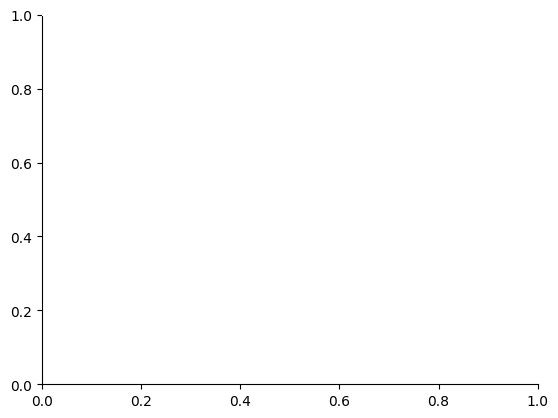

In [12]:

fig, ax = plt.subplots()
for i, unit_id in enumerate([1386]):
   
    wf = waveforms.get_waveforms(unit_id)
    
    #print(int(extremum_channels[unit_id]))
    number = waveforms.channel_ids_to_indices([str(int(extremum_channels_ids[unit_id]))])
    print(wf[:,:, number[0]].shape)
    ax.plot(wf[:,:, number[0]].T,  lw=1, color='black', alpha=0.8, linestyle='-', marker='', markersize=0)
    ax.set_title(f"waveforms of a single putative neuron")
    ax.set_ylabel("Amplitude (µV)")
    ax.set_xlabel("Sampled timepoints (5e-2 ms)")
    ax.set_facecolor('white')  # Set the background color to black

# Customize the appearance of tick labels and axes
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    # ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    # ax.spines['left'].set_color('white')
    
    #plt.savefig(f'/home/mmp/Documents/SyngapTim/waveforms_{unit_id}.svg',format='svg')
    ax.cla()

(140, 1004)
[0]
(140, 1004)
[0]
(140, 1004)
[3]
(140, 1004)
[7]
(140, 1004)
[10]
(140, 1004)
[12]
(140, 1004)
[16]
(140, 1004)
[19]
(140, 1004)
[20]
(140, 1004)
[21]
(140, 1004)
[308]
(140, 1004)
[24]
(140, 1004)
[25]
(140, 1004)
[25]
(140, 1004)
[30]
(140, 1004)
[34]
(140, 1004)
[35]
(140, 1004)
[38]
(140, 1004)
[38]
(140, 1004)
[39]
(140, 1004)
[40]
(140, 1004)
[40]
(140, 1004)
[42]
(140, 1004)
[48]
(140, 1004)
[50]
(140, 1004)
[52]
(140, 1004)
[52]
(140, 1004)
[53]
(140, 1004)
[59]
(140, 1004)
[60]
(140, 1004)
[61]
(140, 1004)
[63]
(140, 1004)
[66]
(140, 1004)
[67]
(140, 1004)
[67]
(140, 1004)
[68]
(140, 1004)
[74]
(140, 1004)
[74]
(140, 1004)
[75]
(140, 1004)
[76]
(140, 1004)
[83]
(140, 1004)
[83]
(140, 1004)
[84]
(140, 1004)
[87]
(140, 1004)
[90]
(140, 1004)
[91]
(140, 1004)
[93]
(140, 1004)
[416]
(140, 1004)
[96]
(140, 1004)
[97]
(140, 1004)
[101]
(140, 1004)
[109]
(140, 1004)
[110]
(140, 1004)
[111]
(140, 1004)
[112]
(140, 1004)
[113]
(140, 1004)
[115]
(140, 1004)
[116]
(140, 10

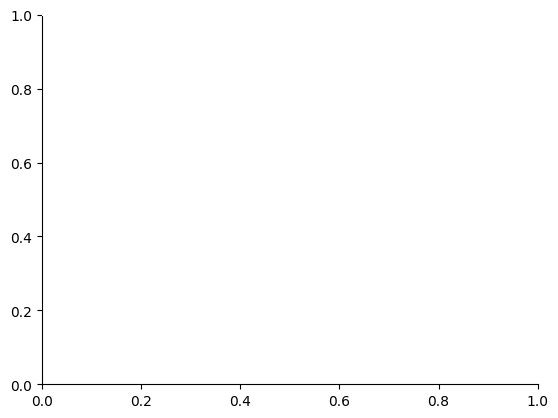

In [11]:




fig, ax = plt.subplots()
for i, unit_id in enumerate(non_violated_units):
    
    template = waveforms.get_template(unit_id,mode='median')
    print(template.shape)
    #print(int(extremum_channels[unit_id]))
    number = waveforms.channel_ids_to_indices([str(int(extremum_channels_ids[unit_id]))])
    print(number)
    ax.plot(template[:, number[0]].T, lw=1, color='black', alpha=0.8, linestyle='-', marker='', markersize=0)
    ax.set_title(f"template of the single putative neuron")
    ax.set_ylabel("Amplitude (µV)")
    ax.set_xlabel("Sampled timepoints (5e-2 ms)")
    ax.set_facecolor('white')  # Set the background color to black

# Customize the appearance of tick labels and axes
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    # ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    # ax.spines['left'].set_color('white')
#FFD700
    plt.savefig(f'/home/mmp/Documents/SyngapTim/templates/templates_{unit_id}.svg',format='svg')
    ax.cla()



In [ ]:
sw.plot_unit_templates(waveforms,unit_ids=[866])

In [ ]:
%matplotlib widget
sw.plot_unit_summary(waveforms,unit_id=588)

In [ ]:
%matplotlib widget
sw.plot_unit_templates(waveform_good,unit_ids=[73])

In [ ]:
trough = min(template[:,channel_association_dict[number]])
peak = max(template[:,channel_association_dict[number]])
peak_index = np.where(template[:,channel_association_dict[number]]==peak)[0]
trough_index = np.where(template[:,channel_association_dict[number]]==trough)[0]
trough_to_peak = (peak_index-trough_index)[0]
#index at half peak. 
half_peak_index = np.where(template[:,channel_association_dict[number]]<=0.5*peak)
half_peak_index= half_peak_index[0][np.where(half_peak_index[0]>peak_index)[0][0]]
repol_time = half_peak_index - peak_index[0]


In [ ]:
waveform_good.unit_ids

In [ ]:
def get_channel_association_dict(recording):
    """
    Takes in recording object and gives a channel association dict.
    
    """
    channel_ids = recording.get_channel_ids()

    return {int(y):x for x,y in enumerate(channel_ids) }

def get_template_characteristics(waveforms):

    """
    returns a pd dataframe of unit templates and their characterisitcs Amplitude, trough to peak time, repolarisation time.

    """

    #get unit ids in the waveform object

    unit_ids = waveforms.unit_ids
    #get extremum channels
    extremum_channels_ids =spikeinterface.full.get_template_extremum_channel(waveform_good, peak_sign='both')

    df = []
    for unit_id in unit_ids:
        
        template = waveforms.get_template(unit_id)

        template_segment = template[:,waveforms.channel_ids_to_indices([str(int(extremum_channels[unit_id]))])]
        trough = min(template_segment)
        peak = max(template_segment)
        peak_index = np.where(template_segment==peak)[0]
        trough_index = np.where(template_segment==trough)[0]
        trough_to_peak = (peak_index-trough_index)[0]
        #index at half peak. 
        half_peak_index = np.where(template_segment<=0.5*peak)
        half_peak_index_2= half_peak_index[0][np.where(half_peak_index[0]>peak_index)[0][0]]
        repol_time = half_peak_index_2 - peak_index[0]
        data = {"Unit": unit_id,"Amp":trough[0],"TTP":trough_to_peak,"REP":repol_time}
        df.append(data)
    df = pd.DataFrame(df)
    return df
        
    

In [ ]:

data= get_template_characteristics(waveform_good)
print(data)

In [ ]:
data.to_excel('new_temp_metrics.xlsx')

In [ ]:
%debug

In [ ]:
w = sw.plot_unit_templates(waveform_good, unit_ids=[183],plot_channels=False )

In [ ]:
w = sw.plot_unit_waveforms(waveform_good, unit_ids=[2,4,7])
w = sw.plot_unit_templates(waveform_good, unit_ids=[2,4,7])
w = sw.plot_unit_probe_map(waveform_good, unit_ids=[2,4,7])

In [ ]:
import spikeinterface_gui

In [ ]:
import importlib
importlib.reload(spikeinterface_gui)

In [ ]:
from spikeinterface.postprocessing import compute_spike_amplitudes, compute_principal_components
from spikeinterface.exporters import export_to_phy

# the waveforms are sparse so it is faster to export to phy
folder = '/home/mmp/disktb/mmpatil/codbase/MEA_Analysis/SpikeSortingPipeline/sorting_intermediate/waveforms/'

we = si.extract_waveforms(recording_chunk,sorting_good,folder=folder,sparse=True)
# some computations are done before to control all options
compute_spike_amplitudes(we)
compute_principal_components(we, n_components=3, mode='by_channel_global')

# the export process is fast because everything is pre-computed
export_to_phy(we, output_folder='path/to/phy_folder')

In [ ]:




# This creates a Qt app
app = spikeinterface_gui.mkQApp() 

# create the mainwindow and show
win = spikeinterface_gui.MainWindow(waveforms)
win.show()
# run the main Qt6 loop
app.exec_()



In [ ]:
# Create a sample dictionary
my_dict = {'key1': 'value1', 'key2': 'value2', 'key3': 'value1', 'key4': 'value3', 'key5':'value2'}

# Create an empty dictionary to store our results
result_dict = {}

# Loop through each key-value pair in my_dict
for key, value in my_dict.items():
    # Check if the value already exists in result_dict
    if value in result_dict:
        # If it does, append the current key to the list of keys that have the same value
        result_dict[value].append(key)
    else:
        # If it doesn't, create a new entry in result_dict with the value as the key and a list containing the current key
        result_dict[value] = [key]

# Create a list called output that contains only the values from result_dict that have more than one key
output = []
for value in result_dict.values():
    if len(value) > 1:
        output.append(value)

# Print the output to the console
print(output)